<a href="https://colab.research.google.com/github/TivoGatto/Thesis/blob/master/Naive_VAE/Naive_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of Naive VAE with architecture taken from Tolsikhin et al.

In [9]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda
from keras.datasets import mnist
import keras.backend as K

In [10]:
# Parameters
input_dim = (32, 32, 1)
latent_dim = 16

epochs = 5
batch_size = 100

beta = 1

In [11]:
# Functions
def vae_loss(z_mean, z_log_var):
    def loss(x_true, x_pred):
        x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
        x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

        L_rec = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        L_KL = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1)

        return K.mean(L_rec + beta * L_KL)
    return loss

def recon(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def KL(z_mean, z_log_var):
    def kl(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))
    return kl

def sampling(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(100, latent_dim)) # 100 = batch_size

    return z_mean + K.exp(0.5 * z_log_var) * eps

def pad(x, d):
    size = x.shape[0]
    h, w = x.shape[1:]

    x = np.reshape(x, (size, h, w, 1))

    x_padded = np.zeros(shape=(size, ) + d)
    x_padded[:, :h, :w] = x

    return x_padded

In [12]:
# Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = pad(x_train, input_dim) / 255 # For MNIST, we pad x_train and x_test in 
x_test  = pad(x_test, input_dim) / 255 # shape (32, 32, 1)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

print('x_train shape: ' + str(x_train.shape))
print('x_test shape: ' + str(x_test.shape))

x_train shape: (60000, 32, 32, 1)
x_test shape: (10000, 32, 32, 1)


In [13]:
# Model Architecture
# ENCODER
x = Input(shape=input_dim) # Shape (32, 32, 1)

h = Conv2D(128, 4, strides=(2, 2), padding='same')(x) # Shape (16, 16, 128)
#h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(256, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 256)
#h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(512, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 512)
#h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(1024, 4, strides=(2, 2), padding='same')(h) # Shape (2, 2, 1024)
#h = BatchNormalization()(h)
h = ReLU()(h)

h = Flatten()(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(x, [z, z_mean, z_log_var])

# DECODER
z_in = Input(shape=(latent_dim, ))

h = Dense(8 * 8 * 1024)(z_in)
h = Reshape((8, 8, 1024))(h)
#h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(512, 4, strides=(2, 2), padding='same')(h) # Shape (16, 16, 512)
#h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(256, 4, strides=(2, 2), padding='same')(h)
#h = BatchNormalization()(h)
h = ReLU()(h)

x_decoded = Conv2DTranspose(1, 4, strides=(1, 1), padding='same', activation='sigmoid')(h)

decoder = Model(z_in, x_decoded)

# VAE
x_recon = decoder(z)

vae = Model(x, x_recon)

# Compile model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)

vae.compile(optimizer=optimizer, loss=vae_loss(z_mean, z_log_var), metrics=[recon, KL(z_mean, z_log_var)])

In [6]:
# Fit model
hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 314s 6ms/step - loss: 21.8727 - recon: 20.6108 - kl: 1.2619 - val_loss: 13.9616 - val_recon: 12.6791 - val_kl: 1.2825
Epoch 2/5
54000/54000 [==============================] - 305s 6ms/step - loss: 11.9816 - recon: 10.8671 - kl: 1.1145 - val_loss: 10.5579 - val_recon: 9.6022 - val_kl: 0.9557
Epoch 3/5
54000/54000 [==============================] - 304s 6ms/step - loss: 9.8748 - recon: 8.9537 - kl: 0.9211 - val_loss: 9.1777 - val_recon: 8.3422 - val_kl: 0.8355
Epoch 4/5
54000/54000 [==============================] - 303s 6ms/step - loss: 8.7621 - recon: 7.9384 - kl: 0.8237 - val_loss: 8.2657 - val_recon: 7.5511 - val_kl: 0.7146
Epoch 5/5
54000/54000 [==============================] - 303s 6ms/step - loss: 8.0317 - recon: 7.2687 - kl: 0.7630 - val_loss: 7.6333 - val_recon: 6.9282 - val_kl: 0.7051


# Generation and Reconstruction

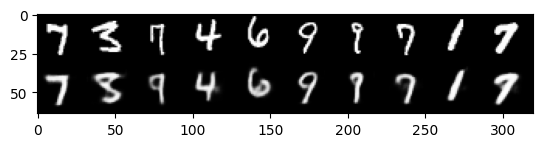

In [7]:
# Reconstruction
n = 10
digit_size = input_dim[0]

x_recon = vae.predict(x_test, batch_size=batch_size)
x_recon = np.reshape(x_recon, (-1, digit_size, digit_size))
x_test = np.reshape(x_test, (-1, digit_size, digit_size))
figure = np.zeros((2 * digit_size, n * digit_size))

for i in range(n):
    sample = np.random.randint(0, len(x_recon))
    figure[:digit_size, i * digit_size: (i+1) * digit_size] = x_test[sample]
    figure[digit_size:, i * digit_size: (i+1) * digit_size] = x_recon[sample]

x_test = np.reshape(x_test, (-1, ) + input_dim)

plt.style.use('default')
plt.imshow(figure, cmap='gray')
plt.show()

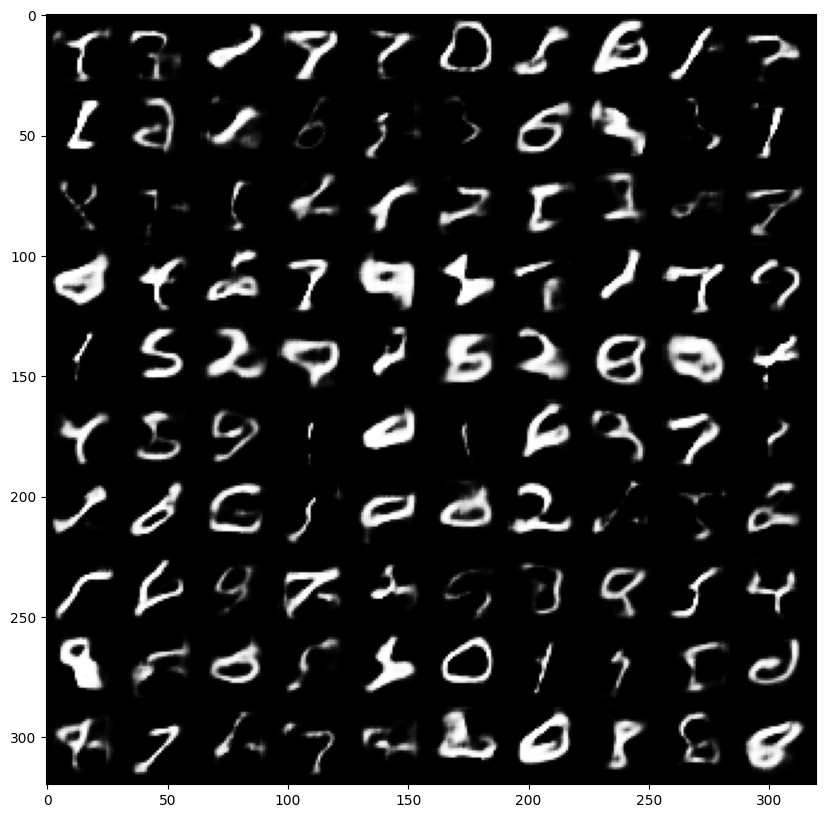

In [8]:
# Generation
n = 10 #figure with n x n digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points randomly sampled

z_sample = np.random.normal(size=(n**2, latent_dim), scale=1)
for i in range(n):
    for j in range(n):
        x_decoded = decoder.predict(np.array([z_sample[i + n * j]]))
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

# Metrics Evaluation

First of all, we want to evaluate the ability of the model of generate high quality samples.

In [ ]:
# FID Score
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

from scipy.linalg import sqrtm
from skimage.transform import resize

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data

# Functions needed to compute FID score
def scale_images(images, new_shape): # Scale an image in a new shape using NN Interpolation
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)


def calculate_fid(model, images1, images2): # Calculate Frechet Inception Distance between images1, images2
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)

	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

	ssdiff = np.sum((mu1 - mu2)**2.0)
	covmean = sqrtm(sigma1.dot(sigma2))

	if np.iscomplexobj(covmean): # Check if the sqrtm is complex
		covmean = covmean.real

	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

sample_size = 10000

z_sample = np.random.normal(0, 1, size=(sample_size, latent_dim))
sample = np.random.randint(0, len(x_test), size=sample_size)
x_gen = decoder.predict(z_sample)
x_real = x_test[sample]

x_gen = evaluate.scale_images(x_gen, (299, 299, 1))
x_real = evaluate.scale_images(x_real, (299, 299, 1))
print('Scaled', x_gen.shape, x_real.shape)

x_gen_t = preprocess_input(x_gen)
x_real_t = preprocess_input(x_real)

x_gen = np.zeros(shape=(sample_size, 299, 299, 3))
x_real = np.zeros(shape=(sample_size, 299, 299, 3))
for i in range(3):
    x_gen[:, :, :, i] = x_gen_t[:, :, :, 0]
    x_real[:, :, :, i] = x_real_t[:, :, :, 0]
print('Final', x_gen.shape, x_real.shape)

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# fid between images1 and images2
fid = evaluate.calculate_fid(model, x_real, x_gen)
print('FID (different): %.3f' % fid)

### Deactivated Latent Variables, Variance Loss and Variance Law


In [13]:
def count_deactivated_variables(z_var, treshold = 0.8):
    z_var = np.mean(z_var, axis=0)

    return np.sum(z_var > treshold)

def loss_variance(x_true, x_recon):
    x_true = np.reshape(x_true, (-1, np.prod(x_true.shape[1:])))
    x_recon = np.reshape(x_recon, (-1, np.prod(x_recon.shape[1:])))

    var_true = np.mean(np.var(x_true, axis=1), axis=0)
    var_recon = np.mean(np.var(x_recon, axis=1), axis=0)

    return np.abs(var_true - var_recon)

########################################################################################################################
# SHOW THE RESULTS
########################################################################################################################

_, z_mean, z_log_var = encoder.predict(x_test, batch_size=batch_size)
z_var = np.exp(z_log_var)
n_deact = count_deactivated_variables(z_var)
print('We have a total of ', latent_dim, ' latent variables. ', count_deactivated_variables(z_var), ' of them are deactivated')

var_law = np.mean(np.var(z_mean, axis=0) + np.mean(z_var, axis=0))
print('Variance law has a value of: ', var_law)

x_recon = vae.predict(x_train, batch_size=batch_size)
print('We lost ', loss_variance(x_test, x_recon), 'Variance of the original data')

We have a total of  10  latent variables.  4  of them are deactivated
Variance law has a value of:  1.1247338
We lost  0.02679167 Variance of the original data


### Latent space matching

In [14]:
# We want to verify if q(z) = p(z).

# Moments Matching
# Generate samples from q(z) and for p(z)
# p(z) = N(0, I)
# q(z) = E_q(x)[q(z|x)]
#
# For every moment we compare the log-moments
n = len(x_test)

p_samples = np.random.normal(size=(n, latent_dim))
q_samples = encoder.predict(x_test, batch_size=batch_size)


from scipy.stats import moment
# First moment matching:
p_first_moment = np.log(np.mean(moment(p_samples, moment=1, axis=0)))
q_first_moment = np.log(np.mean(moment(q_samples, moment=1, axis=0)))

print("\n")
print("First log-moment of p(z): " + str(p_first_moment))
print("First log-moment of q(z): " + str(q_first_moment))
print("\n")

# Second moment matching:
p_second_moment = np.log(np.mean(moment(p_samples, moment=2, axis=0)))
q_second_moment = np.log(np.mean(moment(q_samples, moment=2, axis=0)))

print("\n")
print("Second log-moment of p(z): " + str(p_second_moment))
print("Second log-moment of q(z): " + str(q_second_moment))
print("\n")

# Thid moment matching:
p_third_moment = np.log(np.mean(moment(p_samples, moment=3, axis=0)))
q_third_moment = np.log(np.mean(moment(q_samples, moment=3, axis=0)))

print("\n")
print("Third log-moment of p(z): " + str(p_third_moment))
print("Third log-moment of q(z): " + str(q_third_moment))
print("\n")